In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.max_columns = 300
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

!pip install feature_engine
#from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from plotly.subplots import make_subplots
from plotly import graph_objects as go

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from xgboost import XGBClassifier , XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB

import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 1.0 MB/s eta 0:00:00a 0:00:01


In [2]:
Data = pd.read_csv( '../input/patient-survival-detection-data/Dataset.csv' )
Data

encounter_id  patient_id  hospital_id  hospital_death   age        bmi  \
0             66154       25312          118               0  68.0  22.730000   
1            114252       59342           81               0  77.0  27.420000   
2            119783       50777          118               0  25.0  31.950000   
3             79267       46918          118               0  81.0  22.640000   
4             92056       34377           33               0  19.0        NaN   
...             ...         ...          ...             ...   ...        ...   
91708         91592       78108           30               0  75.0  23.060250   
91709         66119       13486          121               0  56.0  47.179671   
91710          8981       58179          195               0  48.0  27.236914   
91711         33776      120598           66               0   NaN  23.297481   
91712          1671       53612          104               0  82.0  22.031250   

       elective_surgery  ethnicity gender  height hospital_admit_source  \
0                     0  Caucasian      M   180.3                 Floor   
1                     0  Caucasian      F   160.0                 Floor   
2                     0  Caucasian      F   172.7  Emergency Department   
3                     1  Caucasian      F   165.1        Operating Room   
4                     0  Caucasian      M   188.0                   NaN   
...                 ...        ...    ...     ...                   ...   
91708                 0  Caucasian      M   177.8      Acute Care/Floor   
91709                 0  Caucasian      F   183.0  Emergency Department   
91710                 0  Caucasian      M   170.2  Emergency Department   
91711                 0  Caucasian      F   154.9  Emergency Department   
91712                 1  Caucasian      F   160.0                   NaN   

                icu_admit_source  icu_id icu_stay_type      icu_type  \
0                          Floor      92         admit         CTICU   
1                          Floor      90         admit  Med-Surg ICU   
2           Accident & Emergency      93         admit  Med-Surg ICU   
3      Operating Room / Recovery      92         admit         CTICU   
4           Accident & Emergency      91         admit  Med-Surg ICU   
...                          ...     ...           ...           ...   
91708                      Floor     927         admit   Cardiac ICU   
91709                      Floor     925         admit  Med-Surg ICU   
91710       Accident & Emergency     908         admit  Med-Surg ICU   
91711       Accident & Emergency     922         admit  Med-Surg ICU   
91712  Operating Room / Recovery     926         admit  Med-Surg ICU   

       pre_icu_los_days  readmission_status  weight  albumin_apache  \
0              0.541667                   0    73.9             2.3   
1              0.927778                   0    70.2             NaN   
2              0.000694                   0    95.3             NaN   
3              0.000694                   0    61.7             NaN   
4              0.073611                   0     NaN             NaN   
...                 ...                 ...     ...             ...   
91708          0.298611                   0    72.9             NaN   
91709          0.120139                   0   158.0             NaN   
91710          0.046528                   0    78.9             2.9   
91711          0.081944                   0    55.9             NaN   
91712          0.018056                   0    56.4             2.2   

       apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  \
0                   113.0               502.01                      0   
1                   108.0               203.01                      0   
2                   122.0               703.03                      0   
3                   203.0              1206.03                      1   
4                   119.0               601.01    

In [3]:
ID_columns_names = ['encounter_id','patient_id','hospital_id','icu_id']
ID_columns_df = Data[ID_columns_names]
target_feature_name = ['hospital_death']
Data_Target = Data[target_feature_name]
non_imformative_columns_names = ['readmission_status'] # Will be dropped
nominal_columns_names=[ 'hospital_death', 'elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 
                       'icu_stay_type', 'icu_type', 'apache_post_operative','arf_apache', 'gcs_unable_apache', 'intubated_apache',
                       'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus','hepatic_failure','immunosuppression', 
                       'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem' ]
ordinal_columns_names=['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']
numerical_columns_names = list( set(Data.columns.values)-set(ID_columns_names)-set(nominal_columns_names)-set(non_imformative_columns_names) )
Data.drop(columns=ID_columns_names, inplace=True)
Data.drop(columns=non_imformative_columns_names, inplace=True)

# EDA

In [4]:
fig = px.histogram(Data, x="hospital_admit_source", color="hospital_death").update_xaxes(categoryorder='total descending')
fig.show()

In [5]:
fig = px.histogram(Data, x="icu_admit_source", color="icu_type").update_xaxes(categoryorder='total descending')
fig.show()

In [6]:
pd.crosstab(index=Data['hospital_death'], columns=Data['icu_type'])

icu_type        CCU-CTICU  CSICU  CTICU  Cardiac ICU  MICU  Med-Surg ICU  \
hospital_death                                                             
0                    6614   4359   3762         4282  6765         46160   
1                     542    254    241          494   930          4426   

icu_type        Neuro ICU  SICU  
hospital_death                   
0                    7037  4819  
1                     638   390

<AxesSubplot:ylabel='hospital_death'>

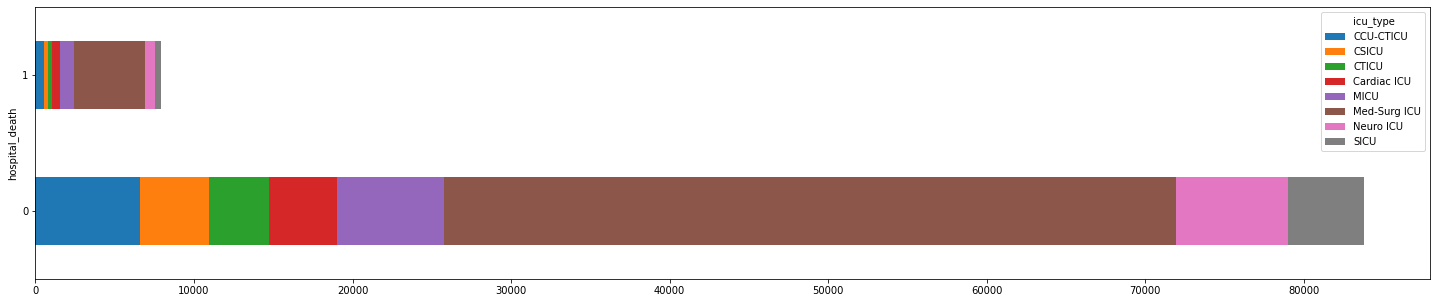

In [7]:
pd.crosstab(index=Data['hospital_death'], columns=Data['icu_type']).plot.barh(figsize=(25,5),stacked=True)

In [8]:
pd.crosstab(index=Data['hospital_death'], columns=Data['ethnicity'])

ethnicity       African American  Asian  Caucasian  Hispanic  Native American  \
hospital_death                                                                  
0                           8797   1036      64516      3420              718   
1                            750     93       6168       376               70   

ethnicity       Other/Unknown  
hospital_death                 
0                        4021  
1                         353

<AxesSubplot:ylabel='hospital_death'>

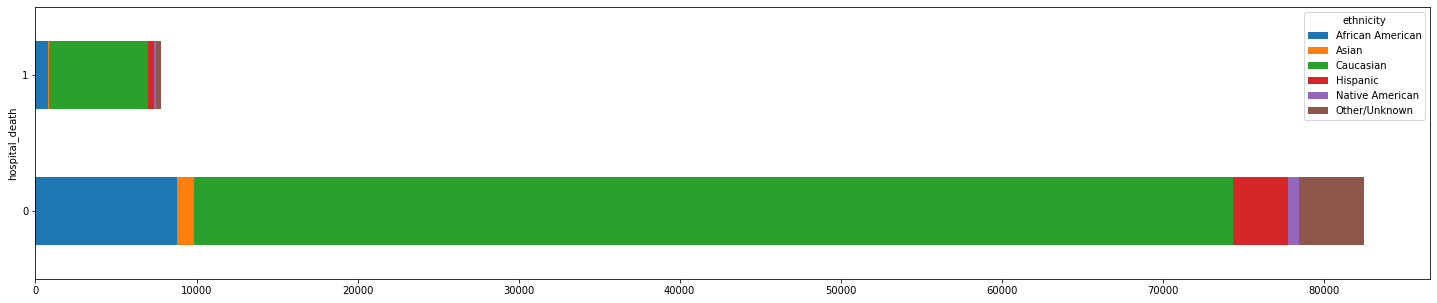

In [9]:
pd.crosstab(index=Data['hospital_death'], columns=Data['ethnicity']).plot.barh(figsize=(25,5),stacked=True)

In [10]:
pd.crosstab(index=Data['hospital_death'], columns=Data['apache_3j_bodysystem'])

apache_3j_bodysystem  Cardiovascular  Gastrointestinal  Genitourinary  \
hospital_death                                                          
0                              27609              8356           2038   
1                               2390               670            134   

apache_3j_bodysystem  Gynecological  Hematological  Metabolic  \
hospital_death                                                  
0                               311            580       7534   
1                                 2             58        116   

apache_3j_bodysystem  Musculoskeletal/Skin  Neurological  Respiratory  Sepsis  \
hospital_death                                                                  
0                                     1111         10956        10308    9886   
1                                       55           940         1301    1854   

apache_3j_bodysystem  Trauma  
hospital_death                
0                       3583  
1                        259

<AxesSubplot:ylabel='hospital_death'>

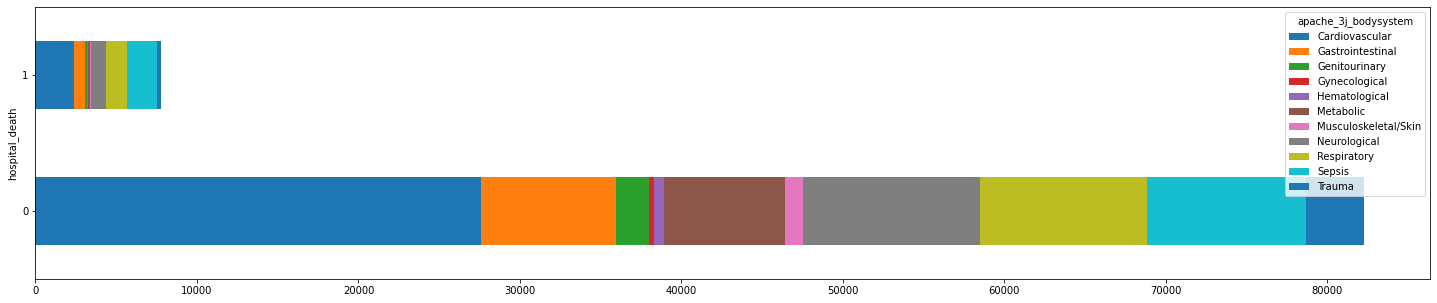

In [11]:
pd.crosstab(index=Data['hospital_death'], columns=Data['apache_3j_bodysystem']).plot.barh(figsize=(25,5),stacked=True)

In [12]:
pd.crosstab(index=Data['hospital_death'], columns=Data['apache_2_bodysystem'])

apache_2_bodysystem  Cardiovascular  Gastrointestinal  Haematologic  \
hospital_death                                                        
0                             34609              8356           580   
1                              4207               670            58   

apache_2_bodysystem  Metabolic  Neurologic  Renal/Genitourinary  Respiratory  \
hospital_death                                                                 
0                         7534       10956                 2324        10308   
1                          116         940                  136         1301   

apache_2_bodysystem  Trauma  Undefined Diagnoses  Undefined diagnoses  
hospital_death                                                         
0                      3583                  328                 3694  
1                       259                   18                   74

<AxesSubplot:ylabel='hospital_death'>

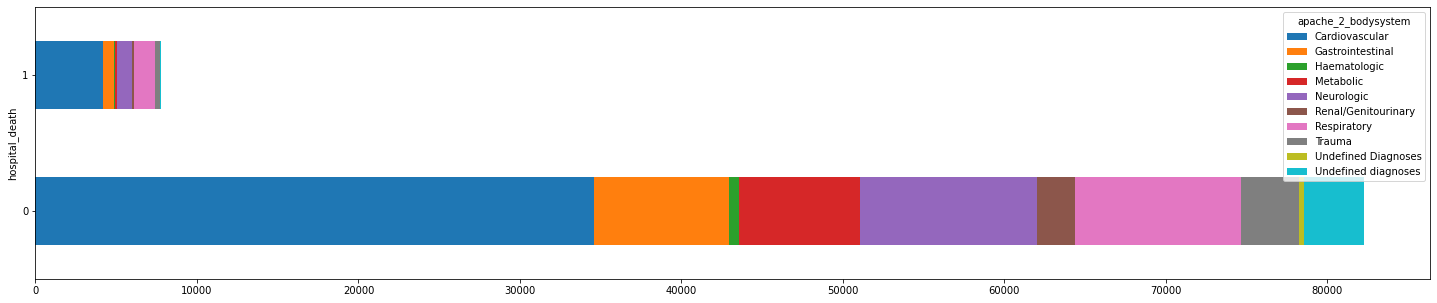

In [13]:
pd.crosstab(index=Data['hospital_death'], columns=Data['apache_2_bodysystem']).plot.barh(figsize=(25,5),stacked=True)

In [14]:
df_groupby_hospital_death = Data[nominal_columns_names].groupby(['hospital_death','gender'],dropna=True).count()
df_groupby_hospital_death

elective_surgery  ethnicity  hospital_admit_source  \
hospital_death gender                                                       
0              F                  38488      37949                  29307   
               M                  45293      44551                  34811   
1              F                   3731       3683                   2891   
               M                   4176       4121                   3273   

                       icu_admit_source  icu_stay_type  icu_type  \
hospital_death gender                                              
0              F                  38447          38488     38488   
               M                  45234          45293     45293   
1              F                   3724           3731      3731   
               M                   4171           4176      4176   

                       apache_post_operative  arf_apache  gcs_unable_apache  \
hospital_death gender                                                         
0              F                       38488       38181              38049   
               M                       45293       44970              44823   
1              F                        3731        3696               3679   
               M                        4176        4126               4101   

                       intubated_apache  ventilated_apache   aids  cirrhosis  \
hospital_death gender                                                          
0              F                  38181              38181  38181      38181   
               M                  44970              44970  44970      44970   
1              F                   3696               3696   3696       3696   
               M                   4126               4126   4126       4126   

                       diabetes_mellitus  hepatic_failure  immunosuppression  \
hospital_death gender                                                          
0              F                   38181            38181              38181   
               M                   44970            44970              44970   
1              F                    3696             3696               3696   
               M                    4126             4126               4126   

                       leukemia  lymphoma  solid_tumor_with_metastasis  \
hospital_death gender                                                    
0              F          38181     38181                        38181   
               M          44970     44970                        44970   
1              F           3696      3696                         3696   
               M           4126      4126                         4126   

                       apache_3j_bodysystem  apache_2_bodysystem  
hospital_death gender                                             
0              F                      37728                37728  
               M                      44528                44528  
1              F                       3676                 3676  
               M                       4095                 4095

<AxesSubplot:xlabel='hospital_death', ylabel='age'>

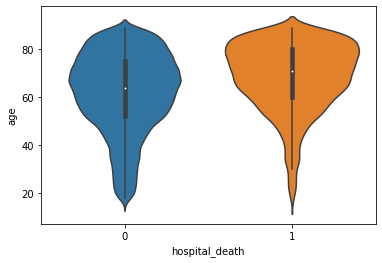

In [15]:
sns.violinplot(y = Data['age'], x = Data['hospital_death'])

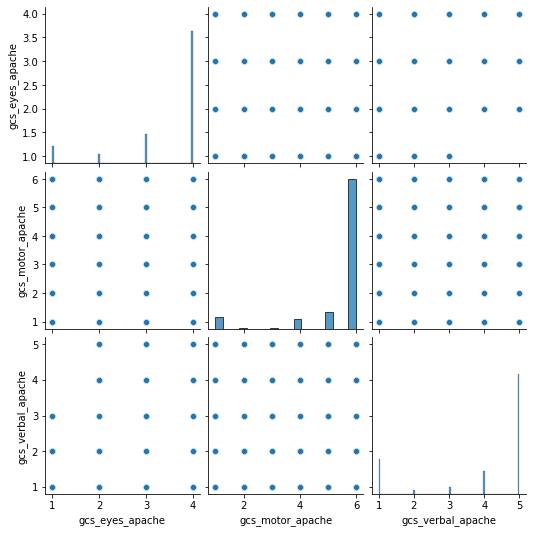

In [16]:
sns.pairplot( Data[ordinal_columns_names] )

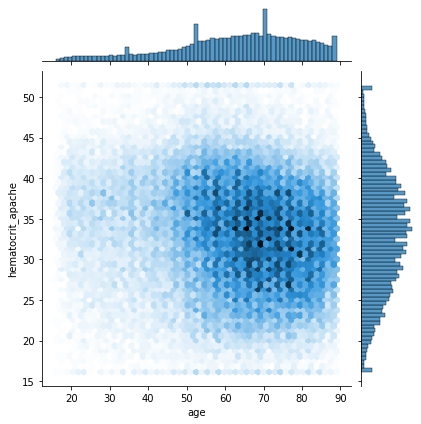

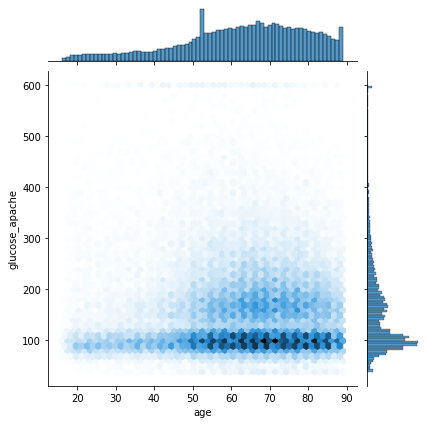

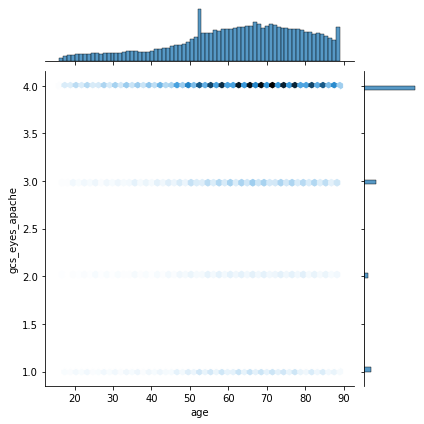

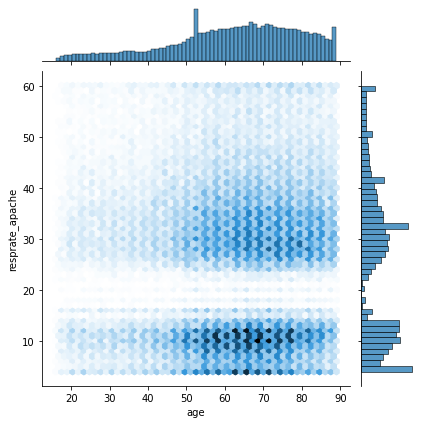

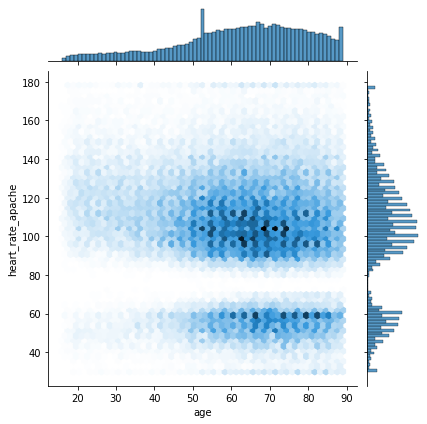

In [17]:
# For Plot 2
sns.jointplot(x = Data['age'], y = Data['hematocrit_apache'], kind = 'hex')
sns.jointplot(x = Data['age'], y = Data['glucose_apache'], kind = 'hex')
sns.jointplot(x = Data['age'], y = Data['gcs_eyes_apache'], kind = 'hex')
sns.jointplot(x = Data['age'], y = Data['resprate_apache'], kind = 'hex')
sns.jointplot(x = Data['age'], y = Data['heart_rate_apache'], kind = 'hex')

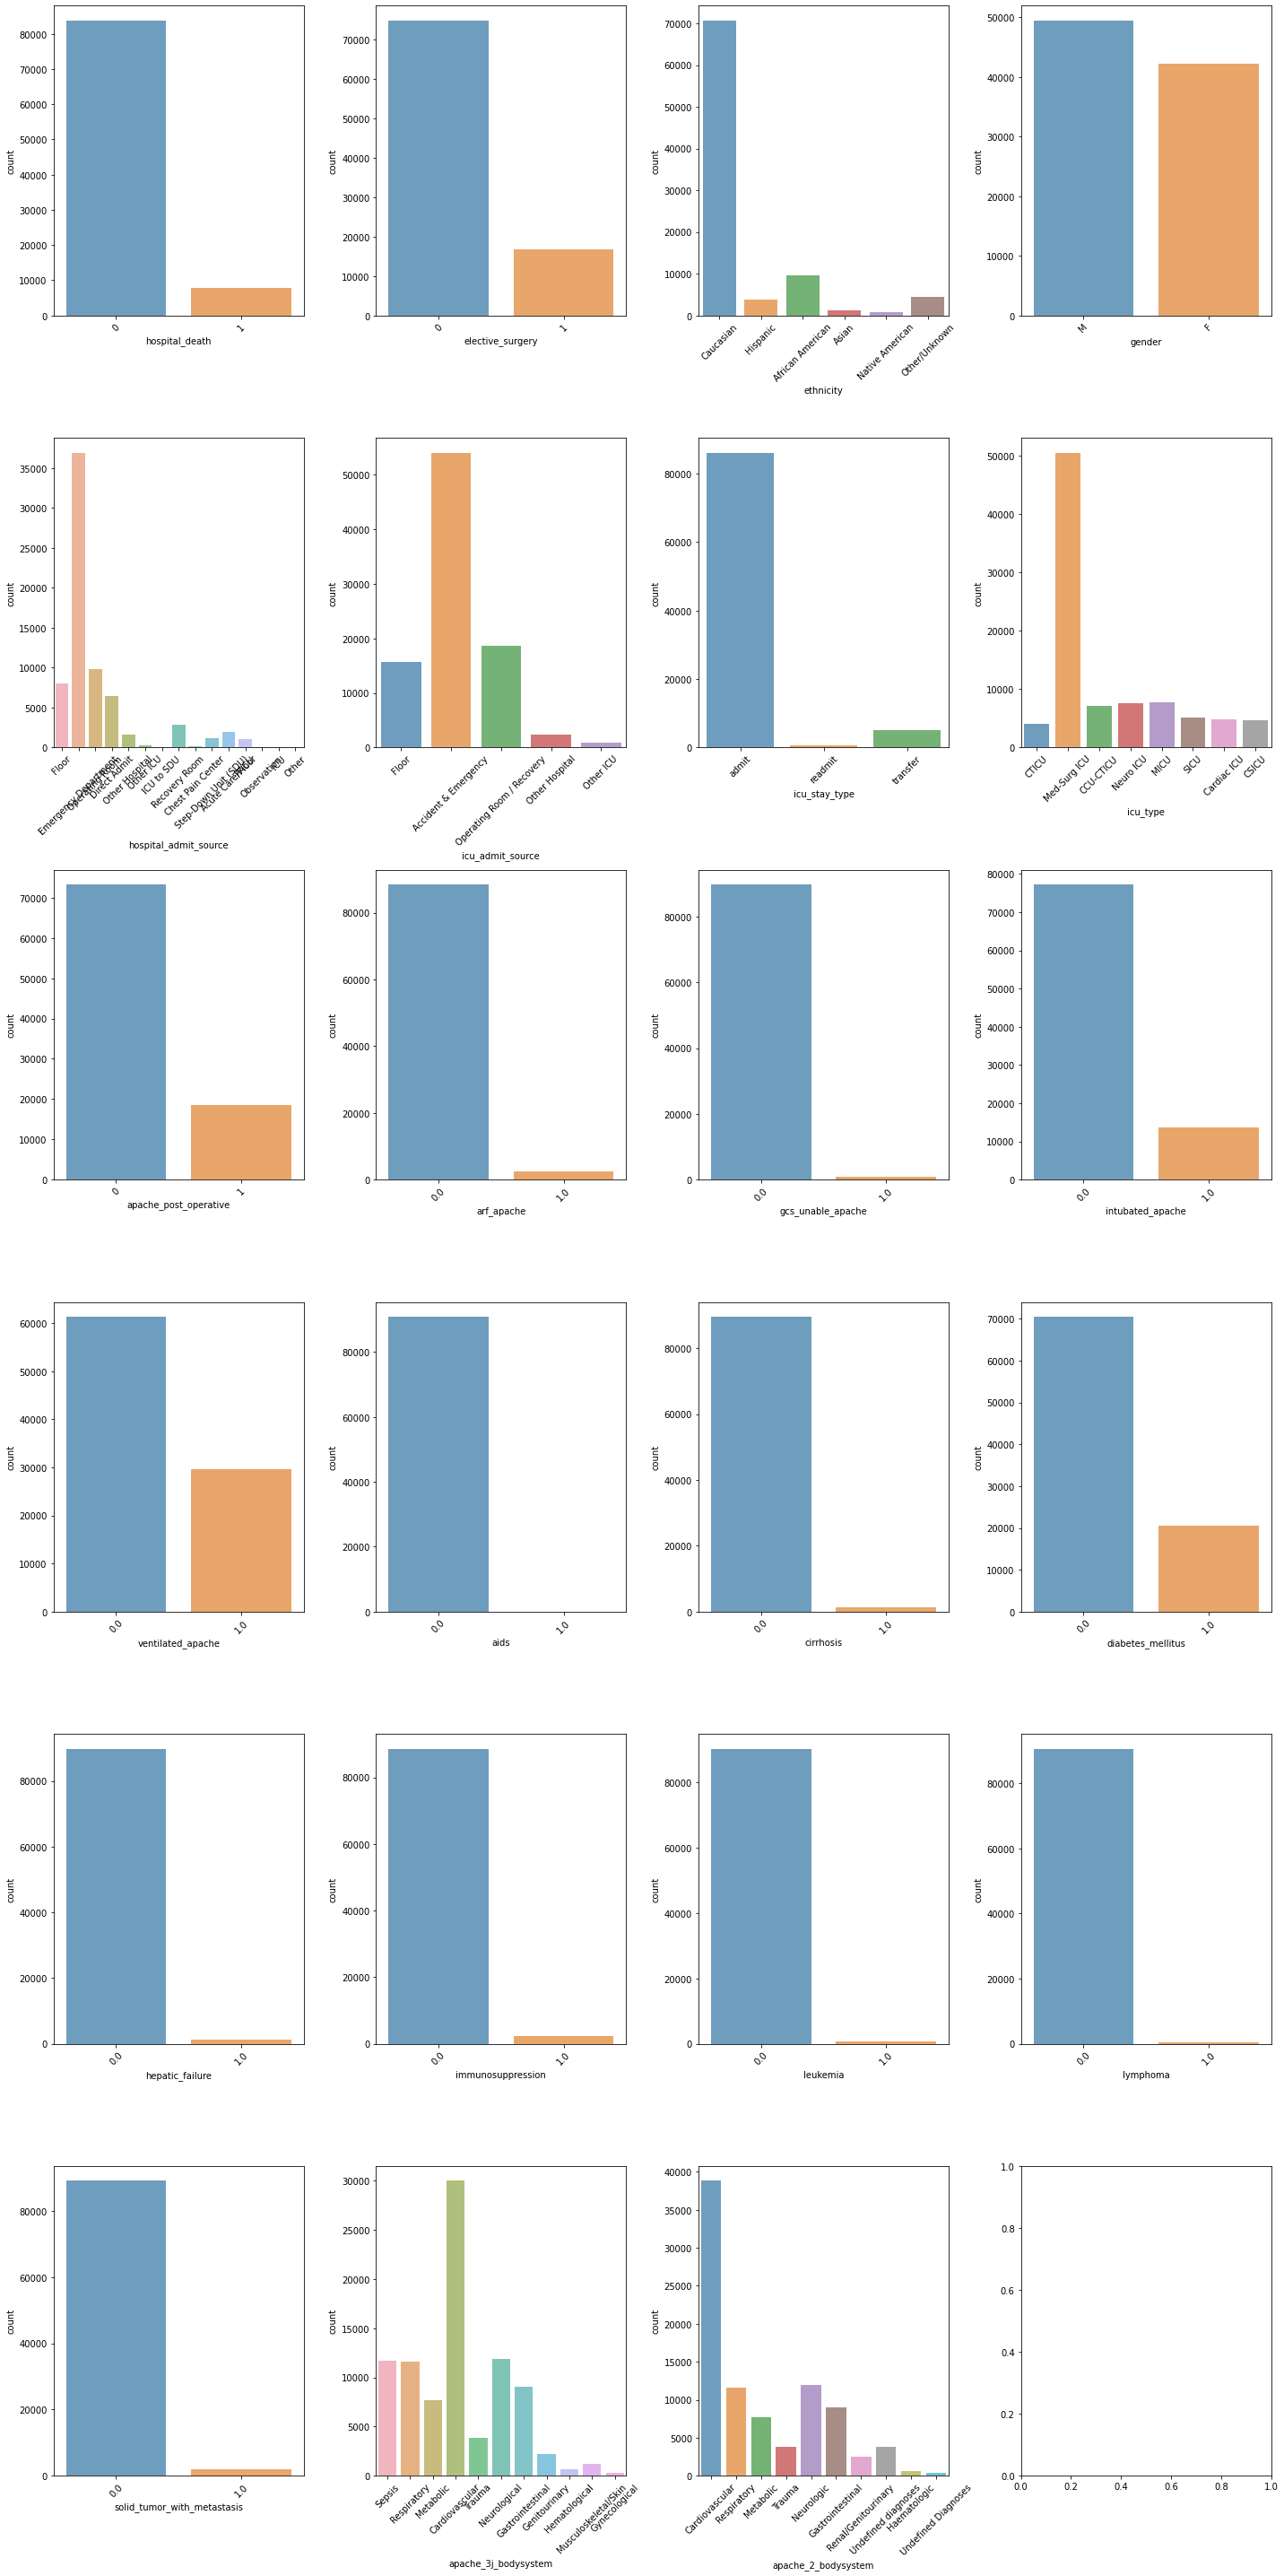

In [18]:
fig, axes = plt.subplots(round(len(nominal_columns_names) / 4), 4, figsize=(20, 40))

for i, ax in enumerate(fig.axes):
    if i < len(nominal_columns_names):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=nominal_columns_names[i], alpha=0.7, data=Data[nominal_columns_names], ax=ax)

fig.tight_layout()

<AxesSubplot:ylabel='Density'>

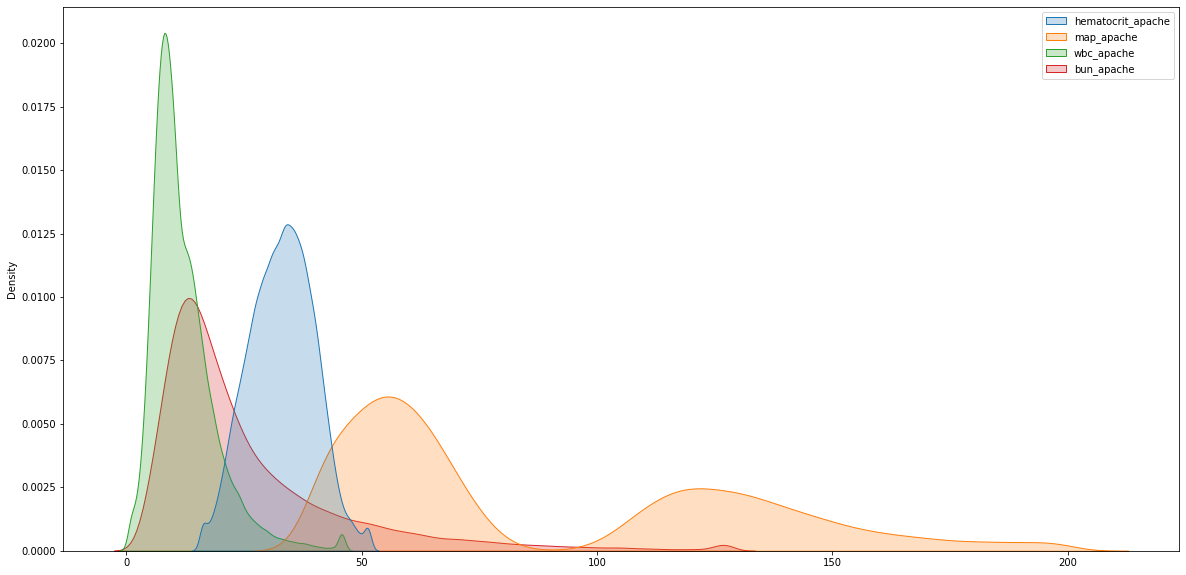

In [19]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=Data[['hematocrit_apache','map_apache','wbc_apache','bun_apache']], shade=True)

<AxesSubplot:ylabel='Density'>

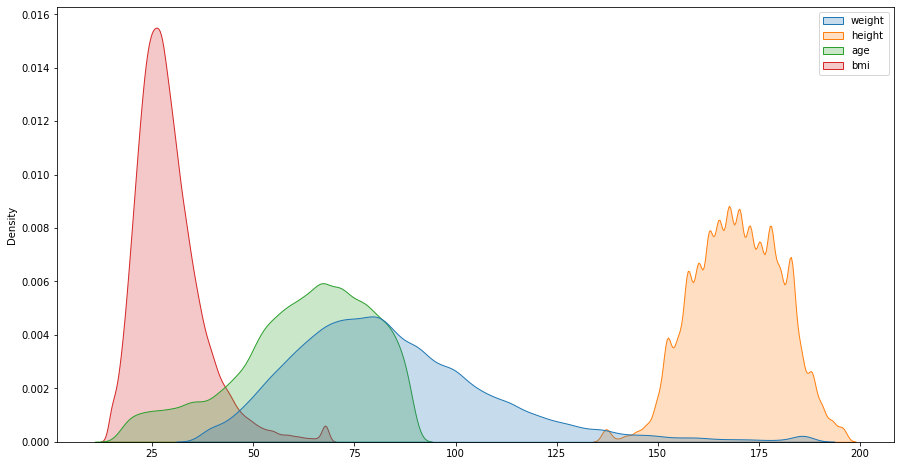

In [20]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=Data[['weight','height','age','bmi']], shade=True)

# Checking Target Feature

In [21]:
Data_Target['hospital_death'].unique()

array([0, 1])

In [22]:
Data_Target.value_counts()

hospital_death
0                 83798
1                  7915
dtype: int64

hospital_death
0                 83798
1                  7915
dtype: int64
-----------------------------


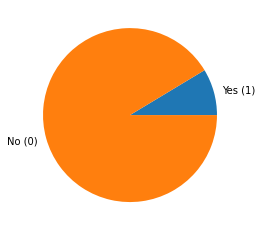

In [23]:
counts_yes = Data_Target.value_counts()[1]
counts_no = Data_Target.value_counts()[0]
plt.pie( [counts_yes, counts_no], labels=['Yes (1)','No (0)'] )
print( Data_Target.value_counts() )
print('-----------------------------')

Target Feature has Imbalanced Distribution

# Data Preprocessing

In [24]:
def unique_missing( df ):  
  for column in df.columns.values:
    print( "Feature:- ", column )
    print("Unique Values:-", list( df[column].unique() ) )
    print('Percentage of Missing Values:- ', df[column].isnull().sum()/df[column].shape[0]*100 )
    print("--------------------------------------------------------------")
    print("\n")

# unique_missing( Data )

# Ordinal Features

In [25]:
unique_missing(Data[ordinal_columns_names])

Feature:-  gcs_eyes_apache
Unique Values:- [3.0, 1.0, 4.0, nan, 2.0]
Percentage of Missing Values:-  2.072770490552048
--------------------------------------------------------------


Feature:-  gcs_motor_apache
Unique Values:- [6.0, 3.0, nan, 4.0, 5.0, 1.0, 2.0]
Percentage of Missing Values:-  2.072770490552048
--------------------------------------------------------------


Feature:-  gcs_verbal_apache
Unique Values:- [4.0, 1.0, 5.0, nan, 3.0, 2.0]
Percentage of Missing Values:-  2.072770490552048
--------------------------------------------------------------




In [26]:
def most_frequent_imputer( df, feature ):
  SI = SimpleImputer( strategy='most_frequent' )
  SI.fit( df[[feature]] )
  df[feature] = SI.transform( df[[feature]] )
  return df, SI

In [27]:
Data, SI_Age_band_of_driver = most_frequent_imputer( Data, feature='gcs_eyes_apache' )
Data, SI_Age_band_of_driver = most_frequent_imputer( Data, feature='gcs_motor_apache' )
Data, SI_Age_band_of_driver = most_frequent_imputer( Data, feature='gcs_verbal_apache' )

# Nominal Features

In [28]:
unique_missing(Data[nominal_columns_names])

Feature:-  hospital_death
Unique Values:- [0, 1]
Percentage of Missing Values:-  0.0
--------------------------------------------------------------


Feature:-  elective_surgery
Unique Values:- [0, 1]
Percentage of Missing Values:-  0.0
--------------------------------------------------------------


Feature:-  ethnicity
Unique Values:- ['Caucasian', nan, 'Hispanic', 'African American', 'Asian', 'Native American', 'Other/Unknown']
Percentage of Missing Values:-  1.5210493605050537
--------------------------------------------------------------


Feature:-  gender
Unique Values:- ['M', 'F', nan]
Percentage of Missing Values:-  0.027258949112993792
--------------------------------------------------------------


Feature:-  hospital_admit_source
Unique Values:- ['Floor', 'Emergency Department', 'Operating Room', nan, 'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU', 'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)', 'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'O

In [29]:
Data, SI_cirrhosis = most_frequent_imputer( Data, feature='cirrhosis' )
Data, SI_diabetes_mellitus = most_frequent_imputer( Data, feature='diabetes_mellitus' )
Data, SI_hepatic_failure = most_frequent_imputer( Data, feature='hepatic_failure' )
Data, SI_immunosuppression = most_frequent_imputer( Data, feature='immunosuppression' )
Data, SI_leukemia = most_frequent_imputer( Data, feature='leukemia' )
Data, SI_lymphoma = most_frequent_imputer( Data, feature='lymphoma' )
Data, SI_solid_tumor_with_metastasis = most_frequent_imputer( Data, feature='solid_tumor_with_metastasis' )
Data, SI_apache_3j_bodysystem = most_frequent_imputer( Data, feature='apache_3j_bodysystem' )
Data, SI_apache_2_bodysystem = most_frequent_imputer( Data, feature='apache_2_bodysystem' )
Data, SI_ethnicity = most_frequent_imputer( Data, feature='ethnicity' )
Data, SI_gender = most_frequent_imputer( Data, feature='gender' )
Data, SI_icu_admit_source = most_frequent_imputer( Data, feature='icu_admit_source' )
Data, SI_gcs_unable_apache = most_frequent_imputer( Data, feature='gcs_unable_apache' )
Data, SI_intubated_apache = most_frequent_imputer( Data, feature='intubated_apache' )
Data, SI_ventilated_apache = most_frequent_imputer( Data, feature='ventilated_apache' )
Data, SI_aids = most_frequent_imputer( Data, feature='aids' )
Data, SI_arf_apache = most_frequent_imputer( Data, feature='arf_apache' )

In [30]:
from feature_engine.encoding import OneHotEncoder
nominal_feature_names_for_encoding = ['ethnicity', 'gender' ,'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem' ]
ohe_nominal_feature_names = OneHotEncoder(variables=nominal_feature_names_for_encoding, top_categories=8)
ohe_nominal_feature_names.fit(Data)
Data = ohe_nominal_feature_names.transform( Data )

In [31]:
fig = px.histogram(Data, x="hospital_admit_source")
fig.show()

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit( Data['hospital_admit_source'] )
Data['hospital_admit_source'] = LE.transform( Data['hospital_admit_source'] )

# Numerical features


In [32]:
def missing( df ):
    high_missing_values_features = []
    missing_values_features_less_5 = []
    missing_values_features_btw_5_and_25 = []
    missing_values_features = []
    for column in df.columns.values:
       # print( "Feature:- ", column )
        percent_missing = df[column].isnull().sum()/df[column].shape[0]*100
       # print('Percentage of Missing Values:- ', percent_missing )
    
        if percent_missing>=25:
            high_missing_values_features.append( column )
        elif percent_missing<=25:
            missing_values_features_less_5.append( column )
        elif percent_missing>5 & percent_missing<=25:
            missing_values_features_btw_5_and_25.append( column )
       # print("--------------------------------------------------------------")
       # print("\n")
    return missing_values_features_less_5, missing_values_features_btw_5_and_25,  high_missing_values_features

In [33]:
missing_values_features_less_5, missing_values_features_btw_5_and_25,  high_missing_values_features = missing( Data[numerical_columns_names] )

|  Features having large number of missing values  |  Drop these features  |


In [34]:
Data[high_missing_values_features]
len( high_missing_values_features )
Data.drop( columns=high_missing_values_features, inplace=True )

# Train Test Split
And Imputing High Missing Values 

In [35]:
X_train, X_test, y_train, y_test = train_test_split( Data.drop(['hospital_death'], axis=1), Data[['hospital_death']], test_size=0.25, random_state=10, stratify=Data[['hospital_death']])

In [36]:
from feature_engine.imputation import MeanMedianImputer
mean_imputer = MeanMedianImputer( imputation_method='mean', variables=missing_values_features_less_5 )
mean_imputer.fit( X_train )
X_train = mean_imputer.transform( X_train )
X_test = mean_imputer.transform( X_test )

In [37]:
df_temp_train = X_train[['hospital_admit_source']]
df_temp_test = X_test[['hospital_admit_source']]
X_train.drop(columns=['hospital_admit_source'], inplace=True)
X_test.drop(columns=['hospital_admit_source'], inplace=True)

In [38]:
xgb_imputer = IterativeImputer( estimator=XGBRegressor(), max_iter=10, random_state=10, skip_complete=True ) 
mean_imputer.fit( X_train )
X_train = mean_imputer.transform( X_train )
X_test = mean_imputer.transform( X_test )

In [39]:
X_train = pd.concat([X_train, df_temp_train ], axis=1)
X_test = pd.concat([ X_test, df_temp_test ], axis=1)

In [40]:
xgb_imputer = IterativeImputer( estimator=XGBClassifier(), max_iter=10, random_state=10, skip_complete=True ) 
mean_imputer.fit( X_train )
X_train = mean_imputer.transform( X_train )
X_test = mean_imputer.transform( X_test )

# Applying ML Models

## Applying upsampling using SMOTE

In [41]:
X_train

age        bmi  elective_surgery  height  pre_icu_los_days  \
68201  86.0  26.094919                 0  167.60          0.283333   
64081  85.0  21.077195                 0  163.00          0.158333   
90418  32.0  27.172065                 0  175.30          0.000000   
57828  64.0  24.076389                 0  167.60          0.000000   
20929  66.0  29.185665                 0  170.00          0.055556   
...     ...        ...               ...     ...               ...   
25569  65.0  30.163127                 0  171.00          0.084722   
34063  71.0  28.355269                 0  172.72          0.103472   
38936  59.0  30.153337                 0  167.60          0.204167   
55600  73.0  42.013682                 0  164.00          0.743750   
28834  75.0  35.493361                 0  167.60          0.065972   

           weight  apache_2_diagnosis  apache_3j_diagnosis  \
68201   73.300000               113.0               501.05   
64081   56.000000               308.0              1101.01   
90418   83.500000               122.0               703.03   
57828   67.630000               113.0               501.06   
20929   84.009864               102.0               206.01   
...           ...                 ...                  ...   
25569   88.200000               301.0               403.01   
34063   84.590000               301.0               405.01   
38936   84.700000               303.0               211.09   
55600  113.000000               108.0               203.01   
28834   99.700000               303.0               211.08   

       apache_post_operative  arf_apache  bun_apache  creatinine_apache  \
68201                      0         0.0   21.000000           3.500000   
64081                      0         0.0   33.000000           1.670000   
90418                      0         0.0    7.000000           0.710000   
57828                      0         0.0   61.000000           1.980000   
20929                      0         0.0   63.000000           3.130000   
...                      ...         ...         ...                ...   
25569                      0         0.0   25.904233           1.488276   
34063                      0         0.0   14.000000           0.830000   
38936                      0         0.0   34.000000           6.970000   
55600                      0         0.0   25.904233           1.488276   
28834                      0         0.0   35.000000           0.630000   

       gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  \
68201              4.0               6.0                0.0   
64081              4.0               6.0                0.0   
90418              3.0               6.0                0.0   
57828              4.0               6.0                0.0   
20929              4.0               6.0                0.0   
...                ...               ...                ...   
25569              4.0               6.0                0.0   
34063              4.0               6.0                0.0   
38936              4.0               6.0                0.0   
55600              4.0               6.0                0.0   
28834              1.0               5.0                0.0   

       gcs_verbal_apache  glucose_apache  heart_rate_apache  \
68201                4.0       93.000000               92.0   
64081                5.0       91.000000              114.0   
90418                4.0      109.000000               43.0   
57828                5.0      206.000000              114.0   
20929                5.0      208.000000              115.0   
...                  ...             ...                ...   
25569                5.0      160.475331               51.0   
34063                5.0      171.000000              116.0   
38936                5.0       88.000000              116.0   
55600                5.0      160.475331              114.0   
28834                1.0      176.000000              110.0   

       

In [42]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote , y_train_smote = smote.fit_resample( X_train, y_train )

fig = go.Figure()
fig.add_trace( go.Histogram( x = y_train, name='hospital_death' ) )
fig.add_trace( go.Histogram( x = y_train_smote , name='hospital_death_smote' ) )
fig.show()

## Applying Model wuth default parameters and Evaluation

In [43]:
def Evaluation(model,X_train,X_test,y_train,y_test,hypertuning=False):

  plt.figure(  figsize=(12,6) )
  print( "-----------------------------------------------------------------------------------------------------------")
  print( model )
  print( " For Train Set :  ")
  y_pred = model.predict(X_train)
  y_pred_proba = model.predict_proba(X_train)

  if hypertuning==True:
    print("Param for GS", model.best_params_)
    print("CV score for GS", model.best_score_)

  accuracy_train = accuracy_score( y_train, y_pred )
  precision_train = precision_score( y_train, y_pred, average='weighted' )
  recall_train = recall_score(y_train, y_pred, average='weighted')
  F1_score_train = f1_score(y_train, y_pred, average='weighted')
  print("F1_Score = ", F1_score_train )
  roc_auc_train = roc_auc_score(y_train, y_pred_proba[:,1], average='weighted')
  print(" ROC AUC Score ", roc_auc_train )
  print( classification_report( y_train, y_pred ) )

  print( " For Test Set :  ")
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)

  accuracy_test = accuracy_score( y_test, y_pred )
  precision_test = precision_score( y_test, y_pred, average='weighted' )
  recall_test = recall_score(y_test, y_pred, average='weighted')
  F1_score_test = f1_score(y_test, y_pred, average='weighted')
  print("F1_Score = ", F1_score_test )
  roc_auc_test = roc_auc_score(y_test, y_pred_proba[:,1], average='weighted')
  print(" ROC AUC Score ", roc_auc_test )
  print( classification_report( y_test, y_pred ) )

  print('------------------------------------------------------------------------------------------------------------')
  print("\n")

  # fpr, tpr, thresh = roc_curve( y_test, y_pred )
  # plt.plot( fpr, tpr, label=model + str( auc_score ) ) 
  return  accuracy_train, precision_train, recall_train, F1_score_train, roc_auc_train, accuracy_test, precision_test, recall_test, F1_score_test, roc_auc_test

In [44]:
def apply_models_with_default_paramters(X_train,X_test,y_train,y_test):
  models_default = [ RandomForestClassifier(), XGBClassifier(), MLPClassifier()
                    # KNeighborsClassifier(), GaussianNB()
                     ]

  
  F1_Score_train = []
  Accuracy_train = []
  Recall_train = []
  Precision_train = []
  ROC_AUC_Score_train = []


  F1_Score_test = []
  Accuracy_test = []
  Recall_test = []
  Precision_test = []
  ROC_AUC_Score_test = []

  Model_Name = []

  for model in models_default:
    Model_Name.append( model )
    model.fit(X_train, y_train)

    accuracy_train, precision_train, recall_train, F1_score_train, roc_auc_train, accuracy_test, precision_test, recall_test, F1_score_test, roc_auc_test = Evaluation(model,X_train,X_test,y_train,y_test,False)
    
    F1_Score_train.append( F1_score_train )
    Accuracy_train.append( accuracy_train )
    Recall_train.append( recall_train )
    Precision_train.append( precision_train )
    ROC_AUC_Score_train.append( roc_auc_train )

    F1_Score_test.append( F1_score_test )
    Accuracy_test.append( accuracy_test )
    Recall_test.append( recall_test )
    Precision_test.append( precision_test )
    ROC_AUC_Score_test.append( roc_auc_test )
    
  results = pd.DataFrame()
  results['Model_Name'] = Model_Name

  train_test_f1_score_difference = np.subtract(F1_Score_train,F1_Score_test)  # To Check Overfitting/Underfitting

  results['F1_Score on Test Set'] = F1_Score_test
  results['Accuracy on Test Set'] = Accuracy_test
  results['Recall on Test Set'] = Recall_test
  results['Precision on Test Set'] = Precision_test
  results['ROC_AUC_Score on Test Set'] = ROC_AUC_Score_test

  results['F1_Score on Train Set'] = F1_Score_train
  results['Accuracy on Train Set'] = Accuracy_train
  results['Recall on Train Set'] = Recall_train
  results['Precision on Train Set'] = Precision_train
  results['ROC_AUC_Score on Train Set'] = ROC_AUC_Score_train

  results['Difference of F1_Score on train and test'] = train_test_f1_score_difference

  results = results.sort_values(by=['F1_Score on Test Set','Difference of F1_Score on train and test'],ascending = [False, True]) 

  return results

In [45]:
X_train_smote.shape, X_test.shape

((125696, 139), (22929, 139))

In [46]:
Results = apply_models_with_default_paramters(X_train_smote,X_test,y_train_smote['hospital_death'],y_test['hospital_death'])

-----------------------------------------------------------------------------------------------------------
RandomForestClassifier()
 For Train Set :  
F1_Score =  1.0
 ROC AUC Score  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62848
           1       1.00      1.00      1.00     62848

    accuracy                           1.00    125696
   macro avg       1.00      1.00      1.00    125696
weighted avg       1.00      1.00      1.00    125696

 For Test Set :  
F1_Score =  0.911102496999234
 ROC AUC Score  0.8820462348694706
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     20950
           1       0.52      0.40      0.45      1979

    accuracy                           0.92     22929
   macro avg       0.73      0.68      0.70     22929
weighted avg       0.91      0.92      0.91     22929

---------------------------------------------------------------------------

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

All above three models are overfitting

# Applying ANN Model

In [47]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.callbacks import EarlyStopping
import keras_tuner as kt

In [48]:
# Plotting Loss vs epochs graph, Accuaracy vs epochs graph
def Plot_Loss_Accuracy( history, epochs ):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = np.linspace(1,epochs,epochs)
    epochs


    fig = go.Figure(data=go.Scatter( x=epochs, y=loss, name='loss' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_loss, name='val_loss' ) )
    fig.update_layout( title="Loss", xaxis_title='epochs' )
    fig.show()


    fig = go.Figure(data=go.Scatter(x=epochs, y=accuracy, name='accuracy' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_accuracy, name='val_accuracy' ) )
    fig.update_layout( title="Accuracy",xaxis_title='epochs' )
    fig.show()

In [49]:
auc_roc_metric = tf.keras.metrics.AUC(curve='ROC')

# Neural network
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy',auc_roc_metric])

2022-08-07 15:24:11.801543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 15:24:11.802795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 15:24:11.803491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 15:24:11.804395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [50]:
history = model.fit(X_train, y_train , validation_data=(X_test,y_test), epochs=10, batch_size=32)

2022-08-07 15:24:18.991872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2150/2150 [==============================] - 11s 4ms/step - loss: 0.4131 - accuracy: 0.9002 - auc: 0.7210 - val_loss: 0.2913 - val_accuracy: 0.8937 - val_auc: 0.8347
Epoch 2/10
2150/2150 [==============================] - 9s 4ms/step - loss: 0.2493 - accuracy: 0.9149 - auc: 0.7930 - val_loss: 0.2487 - val_accuracy: 0.9116 - val_auc: 0.8422
Epoch 3/10
2150/2150 [==============================] - 9s 4ms/step - loss: 0.2345 - accuracy: 0.9186 - auc: 0.8179 - val_loss: 0.2228 - val_accuracy: 0.9185 - val_auc: 0.8448
Epoch 4/10
2150/2150 [==============================] - 8s 4ms/step - loss: 0.2264 - accuracy: 0.9193 - auc: 0.8340 - val_loss: 0.2348 - val_accuracy: 0.9168 - val_auc: 0.8595
Epoch 5/10
2150/2150 [==============================] - 9s 4ms/step - loss: 0.2242 - accuracy: 0.9191 - auc: 0.8386 - val_loss: 0.2187 - val_accuracy: 0.9209 - val_auc: 0.8521
Epoch 6/10
2150/2150 [==============================] - 9s 4ms/step - loss: 0.2212 - accuracy: 0.9205 - auc: 0.8440 - v

In [51]:
Plot_Loss_Accuracy( history, epochs=10 )

# Keras Tuner ANN Model

There is no overfitting we will not apply Dropout or Regularization Layers

In [52]:
def hypertuning_model(hp):
    model = Sequential()
    model.add( InputLayer( input_shape=X_train.shape[1] ))
              
    for num_layer in range(2,hp.Int('No_of_Layers',min_value=2,max_value=6) ):
              model.add( Dense( hp.Int('layer'+str(num_layer), min_value=10, max_value=560, step=50), activation='relu')) # kernel_regularizer=regularizers.l2( l2hp.Choice('Regularization L2', [0.0001,0.0005,0.001,0.005, 0.01])
              # model.add( Dropout( hp.Choice('rate',values=[0.05,0.1,0.2,0.3] )))
              model.add( BatchNormalization() )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy', auc_roc_metric ],
                  # optimizer='Adam',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4]))
                  # optimizer=tf.optimizers.Adam(learning_rate=hp.Choice('Learning Rate', [1e-1,1e-2,1e-3,1e-4]))
                 )
    return model

In [53]:
hyper_tuner_model = kt.Hyperband( hypertuning_model, objective='val_loss',overwrite=True, max_epochs=25,seed=10 )

In [54]:
call_back = EarlyStopping(monitor='val_loss',patience=2)
hyper_tuner_model.search( X_train,y_train, validation_data=(X_test,y_test), epochs=50, callbacks=[call_back] )

Trial 30 Complete [00h 00m 35s]
val_loss: 0.488545298576355

Best val_loss So Far: 0.20596997439861298
Total elapsed time: 00h 33m 11s


In [55]:
best_hyperparameters = hyper_tuner_model.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'No_of_Layers': 5,
 'learning_rate': 0.0001,
 'layer2': 410,
 'layer3': 360,
 'layer4': 60,
 'layer5': 310,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 9,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0014'}

In [56]:
n_best_models = hyper_tuner_model.get_best_models(num_models=1)[0]
n_best_models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 410)               57400     
_________________________________________________________________
batch_normalization (BatchNo (None, 410)               1640      
_________________________________________________________________
dense_1 (Dense)              (None, 360)               147960    
_________________________________________________________________
batch_normalization_1 (Batch (None, 360)               1440      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                21660     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

In [57]:
final_model = hyper_tuner_model.hypermodel.build( best_hyperparameters )
history = final_model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=25 )

Epoch 1/25
2150/2150 [==============================] - 15s 7ms/step - loss: 0.4076 - accuracy: 0.8551 - auc: 0.6963 - val_loss: 0.2644 - val_accuracy: 0.9182 - val_auc: 0.8357
Epoch 2/25
2150/2150 [==============================] - 12s 6ms/step - loss: 0.2306 - accuracy: 0.9203 - auc: 0.8308 - val_loss: 0.2217 - val_accuracy: 0.9220 - val_auc: 0.8540
Epoch 3/25
2150/2150 [==============================] - 12s 6ms/step - loss: 0.2144 - accuracy: 0.9231 - auc: 0.8549 - val_loss: 0.2246 - val_accuracy: 0.9198 - val_auc: 0.8629
Epoch 4/25
2150/2150 [==============================] - 13s 6ms/step - loss: 0.2104 - accuracy: 0.9239 - auc: 0.8626 - val_loss: 0.2152 - val_accuracy: 0.9231 - val_auc: 0.8650
Epoch 5/25
2150/2150 [==============================] - 12s 6ms/step - loss: 0.2065 - accuracy: 0.9247 - auc: 0.8691 - val_loss: 0.2155 - val_accuracy: 0.9246 - val_auc: 0.8678
Epoch 6/25
2150/2150 [==============================] - 12s 6ms/step - loss: 0.2036 - accuracy: 0.9261 - auc: 0.872

In [58]:
Plot_Loss_Accuracy( history, epochs=25 )

In [59]:
final_model.save('./Final_Keras_Tuner_Model')

2022-08-07 16:05:23.836336: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Explainable AI

In [61]:
# compute SHAP values
explainer = shap.DeepExplainer(final_model, X_train)
shap_values = explainer.shap_values(X_train)
# sample_data = X_train.sample(50)
# shap_values = shap.DeepExplainer(final_model,sample_data).shap_values(sample_data)

AttributeError: 'tuple' object has no attribute 'rank'

In [128]:
shap.summary_plot(shap_values[0], plot_type='bar', feature_names = X_test.columns)

NameError: name 'shap_values' is not defined

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_test.columns)

In [ ]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_test.iloc[0,:], feature_names = X_test.columns.tolist())

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names = X_test.columns)